**LSTM**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import os
import glob
from pathlib import Path
import numpy as np, pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

import matplotlib.pyplot as plt


In [3]:
SEED = 556
np.random.seed(SEED)
torch.manual_seed(SEED)

BASE_DIR = "/content/drive/MyDrive/Colab Notebooks/VolSurf_ML"
METRICS_DIR = os.path.join(BASE_DIR, "metrics")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
# ---- Load SVI metrics ----
svi_files = sorted(glob.glob(os.path.join(METRICS_DIR, "svi_metrics_*.parquet")))
print("SVI files:")
for f in svi_files:
    print("  ", os.path.basename(f))

if not svi_files:
    raise RuntimeError("No svi_metrics_*.parquet files found in METRICS_DIR.")

svi_dfs = [pd.read_parquet(f) for f in svi_files]
svi_all = pd.concat(svi_dfs, ignore_index=True)

# Normalise types
svi_all['asof']   = pd.to_datetime(svi_all['asof'])
svi_all['expiry'] = pd.to_datetime(svi_all['expiry'])

# ---- Load SSVI metrics ----
ssvi_files = sorted(glob.glob(os.path.join(METRICS_DIR, "ssvi_metrics_*.parquet")))
print("\nSSVI files:")
for f in ssvi_files:
    print("  ", os.path.basename(f))

if not ssvi_files:
    raise RuntimeError("No ssvi_metrics_*.parquet files found in METRICS_DIR.")

ssvi_dfs = [pd.read_parquet(f) for f in ssvi_files]
ssvi_all = pd.concat(ssvi_dfs, ignore_index=True)

ssvi_all['asof']   = pd.to_datetime(ssvi_all['asof'])
ssvi_all['expiry'] = pd.to_datetime(ssvi_all['expiry'])

# ---- Merge SVI + SSVI on (asof, expiry, T) ----
# Keep only SSVI columns we care about
ssvi_cols = ['asof','expiry','T','theta','ssvi_rho','ssvi_eta','ssvi_p','fit_cost']
if 'calendar_violations' in ssvi_all.columns:
    ssvi_cols.append('calendar_violations')

metrics_all = svi_all.merge(
    ssvi_all[ssvi_cols],
    on=['asof','expiry'],
    how='left',
    suffixes=('', '_ssvi')
)

metrics_all = metrics_all.sort_values(['asof', 'T']).reset_index(drop=True)

# ---- Helper Function to Flatten Array-Wrapped Cells ----
def clean_flatten_cols(df):
    """
    Detects columns containing single-element arrays (e.g. [0.035])
    and flattens them to scalars (0.035).
    """
    for col in df.columns:
        # Skip columns that are already standard floats/ints/dates
        if pd.api.types.is_numeric_dtype(df[col]) or pd.api.types.is_datetime64_any_dtype(df[col]):
            continue

        # Check a non-null sample to see if it's an array/list
        valid_vals = df[col].dropna()
        if valid_vals.empty:
            continue

        sample = valid_vals.iloc[0]
        if isinstance(sample, (np.ndarray, list)):
            print(f"  -> Flattening array-wrapped column: {col}")
            # Extract item() if strictly numpy, or [0] if list-like
            df[col] = df[col].apply(lambda x: x.item() if hasattr(x, 'item') else (x[0] if hasattr(x, '__getitem__') and len(x) > 0 else np.nan))
            # Force to numeric
            df[col] = pd.to_numeric(df[col], errors='coerce')

    return df

# ---- Load RND Features ----
rnd_files = sorted(glob.glob(os.path.join(METRICS_DIR, "rnd_features_*.parquet")))

if rnd_files:
    print(f"Found {len(rnd_files)} RND feature files.")
    rnd_dfs = [pd.read_parquet(f) for f in rnd_files]
    rnd_all = pd.concat(rnd_dfs, ignore_index=True)

    # --- STEP 1: CLEANING (The Fix) ---
    print("Cleaning RND data...")
    rnd_all = clean_flatten_cols(rnd_all)

    # --- STEP 2: DATE NORMALIZATION ---
    if 'asof' not in rnd_all.columns and 'date' in rnd_all.columns:
        rnd_all.rename(columns={'date': 'asof'}, inplace=True)

    if 'asof' in rnd_all.columns:
        rnd_all['asof'] = pd.to_datetime(rnd_all['asof'])
        if rnd_all['asof'].dt.tz is not None:
            rnd_all['asof'] = rnd_all['asof'].dt.tz_localize(None)
        rnd_all['asof'] = rnd_all['asof'].dt.normalize()

    if 'expiry' in rnd_all.columns:
        rnd_all['expiry'] = pd.to_datetime(rnd_all['expiry']).dt.normalize()

    # --- STEP 3: MERGE ---
    # Ensure metrics_all dates are also normalized for matching
    metrics_all['asof'] = pd.to_datetime(metrics_all['asof'])
    if metrics_all['asof'].dt.tz is not None:
        metrics_all['asof'] = metrics_all['asof'].dt.tz_localize(None)
    metrics_all['asof'] = metrics_all['asof'].dt.normalize()
    metrics_all['expiry'] = pd.to_datetime(metrics_all['expiry']).dt.normalize()

    # Drop 'T' from rnd to avoid duplicates/floating point mismatches
    cols_to_use = [c for c in rnd_all.columns if c != 'T']

    # Merge on Date Keys
    metrics_all = metrics_all.merge(
        rnd_all[cols_to_use],
        on=['asof', 'expiry'],
        how='left',
        suffixes=('', '_rnd')
    )

    # --- STEP 4: FILL MISSING RND ---
    # Fallback for days where RND might have failed but SVI existed
    if 'rnd_skew' in metrics_all.columns:
        metrics_all['rnd_skew'] = metrics_all['rnd_skew'].fillna(metrics_all['ATM_skew'])
    if 'rnd_kurtosis' in metrics_all.columns:
        metrics_all['rnd_kurtosis'] = metrics_all['rnd_kurtosis'].fillna(3.0)
    if 'martingale_error' in metrics_all.columns:
        # Fill missing martingale errors with a "high confidence" or "average" value?
        # Usually better to fill with 0.0 (assume okay) or the mean.
        metrics_all['martingale_error'] = metrics_all['martingale_error'].fillna(0.0)

    print(f"RND merged and cleaned. New shape: {metrics_all.shape}")
else:
    print("No RND files found.")


print("\nCombined metrics shape:", metrics_all.shape)


metrics_all.columns

SVI files:
   svi_metrics_2025-12-09.parquet
   svi_metrics_2025-12-10.parquet
   svi_metrics_2025-12-12.parquet

SSVI files:
   ssvi_metrics_2025-12-09.parquet
   ssvi_metrics_2025-12-10.parquet
   ssvi_metrics_2025-12-12.parquet
Found 3 RND feature files.
Cleaning RND data...
  -> Flattening array-wrapped column: F
  -> Flattening array-wrapped column: martingale_error
RND merged and cleaned. New shape: (61, 24)

Combined metrics shape: (61, 24)


Index(['asof', 'expiry', 'T', 'ATM_IV', 'ATM_skew', 'ATM_curvature', 'a', 'b',
       'rho', 'm', 'sigma', 'T_ssvi', 'theta', 'ssvi_rho', 'ssvi_eta',
       'ssvi_p', 'fit_cost', 'calendar_violations', 'F', 'rnd_mean',
       'martingale_error', 'rnd_vol', 'rnd_skew', 'rnd_kurtosis'],
      dtype='object')

In [5]:
metrics_all['asof'] = pd.to_datetime(metrics_all['asof'])
metrics_all = metrics_all.sort_values(['expiry', 'asof']).reset_index(drop=True)
metrics_all['ATM_IV_tplus1'] = metrics_all.groupby('expiry')['ATM_IV'].shift(-1)
missing_mask = metrics_all['ATM_IV_tplus1'].isna()
metrics_all.loc[missing_mask, ['ATM_IV_tplus1']] = metrics_all.loc[missing_mask, 'ATM_IV']
metrics_all['delta_ATM_IV'] = metrics_all['ATM_IV_tplus1'] - metrics_all['ATM_IV']
metrics_all = metrics_all.dropna(subset=['ATM_IV', 'ATM_IV_tplus1', 'delta_ATM_IV']).reset_index(drop=True)
metrics_all.shape

(61, 26)

In [6]:
price_path = os.path.join(BASE_DIR, "hist_price.parquet")
prices = pd.read_parquet(price_path)

# Ensure index is sorted
prices = prices.sort_index()

# If index is timezone-aware (like 2023-11-15 00:00:00-05:00), drop tz
if hasattr(prices.index, "tz") and prices.index.tz is not None:
    # Option 1: convert to UTC then drop tz
    prices.index = prices.index.tz_convert("UTC").tz_localize(None)
    # Option 2 (simpler, also fine here): prices.index = prices.index.tz_localize(None)

# Basic returns and realised vol
prices['return_1d'] = prices['Close'].pct_change()
prices['return_5d'] = prices['Close'].pct_change(5)
prices['rv_20d']    = prices['return_1d'].rolling(20).std() * np.sqrt(252)

# Turn index into a column called 'asof' (date-like, no tz)
prices = prices.reset_index().rename(columns={prices.index.name or 'Date': 'asof'})
prices['asof'] = pd.to_datetime(prices['asof']).dt.normalize()

prices.tail()

,asof,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains,return_1d,return_5d,rv_20d
498,2025-12-08,627.210022,628.840027,621.690002,624.280029,43462400,0.0,0.0,0.0,-0.001918,0.011520,0.188977
499,2025-12-09,623.010010,625.869995,621.000000,625.049988,37156000,0.0,0.0,0.0,0.001233,0.004904,0.172167
500,2025-12-10,623.849976,629.210022,620.989990,627.609985,55031400,0.0,0.0,0.0,0.004096,0.006559,0.172347
501,2025-12-11,623.820007,625.780029,617.719971,625.580017,58036600,0.0,0.0,0.0,-0.003234,0.004238,0.172815
502,2025-12-12,621.950989,623.539978,615.679993,617.400024,21329038,0.0,0.0,0.0,-0.013076,-0.012918,0.162750


In [7]:
metrics_all = metrics_all.merge(
    prices[['asof', 'Close', 'return_1d', 'return_5d', 'rv_20d']],
    on='asof',
    how='left'
)

metrics_all = metrics_all.rename(columns={'Close': 'spot'})
metrics_all = metrics_all.sort_values(['T', 'asof']).reset_index(drop=True)

print("Merged shape:", metrics_all.shape)
metrics_all.tail()

Merged shape: (61, 30)


,asof,expiry,T,ATM_IV,ATM_skew,ATM_curvature,a,b,rho,m,...,martingale_error,rnd_vol,rnd_skew,rnd_kurtosis,ATM_IV_tplus1,delta_ATM_IV,spot,return_1d,return_5d,rv_20d
56,2025-12-10,2027-12-17,2.019178,0.235400,-0.116240,0.232430,-0.033185,0.197599,-0.506912,0.037411,...,0.005576,0.242211,0.036543,4.325949,0.233757,-0.001643,627.609985,0.004096,0.006559,0.172347
57,2025-12-09,2027-12-17,2.021918,0.171370,0.380799,-0.846100,0.046850,0.517969,-0.490525,-0.047479,...,0.148685,0.459836,1.791394,6.420275,0.235400,0.064030,625.049988,0.001233,0.004904,0.172167
58,2025-12-12,2028-01-21,2.109589,0.228043,-0.096656,0.754306,0.041527,0.234092,-0.117464,0.078900,...,0.005608,0.240848,0.057481,4.211464,0.228043,0.000000,617.400024,-0.013076,-0.012918,0.162750
59,2025-12-10,2028-01-21,2.115068,0.230635,-0.099624,0.869198,0.070606,0.193210,-0.257135,0.050158,...,0.006281,0.242283,0.073376,4.318670,0.228043,-0.002592,627.609985,0.004096,0.006559,0.172347
60,2025-12-09,2028-01-21,2.117808,0.242432,-0.606446,0.299847,-0.918781,4.342558,0.713544,0.529870,...,0.149269,0.448562,1.786478,6.394951,0.230635,-0.011797,625.049988,0.001233,0.004904,0.172167


In [8]:
def safe_norm(s: pd.Series) -> pd.Series:

    s = s.astype(float).clip(lower=0)

    arr = s.to_numpy()
    finite_mask = np.isfinite(arr)


    if not finite_mask.any():
        return pd.Series(
            np.zeros_like(arr, dtype=np.float32),
            index=s.index
        )

    mean = arr[finite_mask].mean()
    std = arr[finite_mask].std()


    if not np.isfinite(std) or std == 0.0:
        return pd.Series(
            np.zeros_like(arr, dtype=np.float32),
            index=s.index
        )

    z = (arr - mean) / std

    z[~np.isfinite(z)] = 0.0

    return pd.Series(z.astype(np.float32), index=s.index)


def compute_weights_from_quality(quality: pd.Series, scale: float = 1.0) -> np.ndarray:
    arr = quality.to_numpy(dtype=np.float32)


    if arr.size == 0:
        return np.ones_like(arr, dtype=np.float32)

    finite_mask = np.isfinite(arr)

    if not finite_mask.any():
        return np.ones_like(arr, dtype=np.float32)


    mean_q = arr[finite_mask].mean()
    arr[~finite_mask] = mean_q


    w = 1.0 / (1.0 + scale * np.abs(arr))

    # Normalize mean weight to ~1
    mean_w = w.mean()
    if not np.isfinite(mean_w) or mean_w == 0.0:
        return w.astype(np.float32)

    w /= mean_w
    return w.astype(np.float32)



me_series  = metrics_all['martingale_error']     if 'martingale_error'     in metrics_all.columns else pd.Series(0.0, index=metrics_all.index)
fc_series  = metrics_all['fit_cost']             if 'fit_cost'             in metrics_all.columns else pd.Series(0.0, index=metrics_all.index)
cal_series = metrics_all['calendar_violations']  if 'calendar_violations'  in metrics_all.columns else pd.Series(0.0, index=metrics_all.index)

me_n  = safe_norm(me_series)
fc_n  = safe_norm(fc_series)
cal_n = safe_norm(cal_series)

quality = me_n + fc_n + cal_n

metrics_all['quality_signal'] = quality
metrics_all['sample_weight']  = compute_weights_from_quality(quality, scale=1.0)

print("Sample weight stats:")
print(metrics_all['sample_weight'].describe())
print("Any NaNs in sample_weight?", metrics_all['sample_weight'].isna().any())

Sample weight stats:
count    61.000000
mean      1.000000
std       0.248843
min       0.441449
25%       1.111892
50%       1.112182
75%       1.113827
max       1.181179
Name: sample_weight, dtype: float64
Any NaNs in sample_weight? False


In [9]:
feature_cols = [
    'T',
    'ATM_IV', "ATM_skew", 'ATM_curvature', 'a', 'b',
       'rho', 'm', 'sigma','theta', 'ssvi_rho', 'ssvi_eta',
       'ssvi_p', 'rnd_mean', 'rnd_vol', 'rnd_skew', 'rnd_kurtosis',
    'return_1d', 'rv_20d', 'quality_signal'
]

target_col = 'delta_ATM_IV'
weight_col = 'sample_weight'


In [10]:
# === Time-based train/val/test split (robust on small samples) ===

metrics_all['asof'] = pd.to_datetime(metrics_all['asof'])

unique_dates = np.sort(metrics_all['asof'].unique())
n_dates = len(unique_dates)

print("Number of unique asof dates:", n_dates)
print("First few dates:", unique_dates[:5])
print("Last few dates:", unique_dates[-5:])

if n_dates < 3:
    # Fallback: not enough distinct dates to do 70/15/15 by time.
    # Just do a simple row-based split, still sorted by time.
    df = metrics_all.sort_values('asof').reset_index(drop=True)
    n = len(df)
    train_end = int(0.7 * n)
    val_end   = int(0.85 * n)

    df_train = df.iloc[:train_end].copy()
    df_val   = df.iloc[train_end:val_end].copy()
    df_test  = df.iloc[val_end:].copy()
else:
    # Standard: 70/15/15 split on *dates*, but ensure val and test aren't empty
    train_end_idx = int(0.7 * n_dates)
    val_end_idx   = int(0.85 * n_dates)

    # Ensure at least 1 date in each segment
    train_end_idx = max(1, min(train_end_idx, n_dates - 2))
    val_end_idx   = max(train_end_idx + 1, min(val_end_idx, n_dates - 1))

    train_last_date = unique_dates[train_end_idx - 1]
    val_last_date   = unique_dates[val_end_idx - 1]

    print("Train last date:", train_last_date)
    print("Val last date:  ", val_last_date)

    df_train = metrics_all[metrics_all['asof'] <= train_last_date].copy()
    df_val   = metrics_all[(metrics_all['asof'] > train_last_date) & (metrics_all['asof'] <= val_last_date)].copy()
    df_test  = metrics_all[metrics_all['asof'] > val_last_date].copy()

print("Rows in train/val/test:", len(df_train), len(df_val), len(df_test))

Number of unique asof dates: 3
First few dates: ['2025-12-09T00:00:00.000000000' '2025-12-10T00:00:00.000000000'
 '2025-12-12T00:00:00.000000000']
Last few dates: ['2025-12-09T00:00:00.000000000' '2025-12-10T00:00:00.000000000'
 '2025-12-12T00:00:00.000000000']
Train last date: 2025-12-09T00:00:00.000000000
Val last date:   2025-12-10T00:00:00.000000000
Rows in train/val/test: 15 23 23


In [12]:
scaler_X = StandardScaler()
scaler_X.fit(df_train[feature_cols])

for split_df in [df_train, df_val, df_test]:
  split_df[feature_cols] = scaler_X.transform(split_df[feature_cols])

In [13]:
SEQ_LEN = 1

def build_sequences_for_split(df_split: pd.DataFrame, feature_cols, target_col, seq_len: int):

  X_list, y_list, w_list, meta = [], [], [], []

  for exp_val, df_exp in df_split.groupby('expiry'):
    df_exp = df_exp.sort_values('asof').reset_index(drop=True)

    feats = df_exp[feature_cols].to_numpy(dtype=np.float32)
    targets = df_exp[target_col].to_numpy(dtype=np.float32)
    weights = df_exp[weight_col].to_numpy(dtype=np.float32)
    dates = df_exp['asof'].to_numpy()
    Ts = df_exp['T'].to_numpy()

    if len(df_exp) < seq_len:
      continue

    for end_idx in range(seq_len-1, len(df_exp)):
      start_idx = end_idx - seq_len + 1

      X_window = feats[start_idx:end_idx + 1]
      y_target = targets[end_idx]
      w_target = weights[end_idx]

      if not np.isfinite(y_target):
        continue

      X_list.append(X_window)
      y_list.append(y_target)
      w_list.append(w_target)
      meta.append({ 'expiry':exp_val, 'asof': dates[end_idx], 'T': float(Ts[end_idx]), })

  if not X_list:
    return (
        np.zeros((0, seq_len, len(feature_cols)), dtype=np.float32),
        np.zeros((0,), dtype = np.float32),
        np.zeros((0,), dtype=np.float32),
        meta
    )

  X = np.stack(X_list, axis=0)
  y = np.array(y_list, dtype=np.float32)
  w = np.array(w_list, dtype=np.float32)

  return X, y, w, meta

X_train, y_train, w_train, meta_train = build_sequences_for_split(df_train, feature_cols, target_col, SEQ_LEN)
X_val, y_val, w_val, meta_val = build_sequences_for_split(df_val, feature_cols, target_col, SEQ_LEN)
X_test, y_test, w_test, meta_test = build_sequences_for_split(df_test, feature_cols, target_col, SEQ_LEN)
print("Shapes:", X_train.shape, X_val.shape, X_test.shape)


Shapes: (15, 1, 20) (23, 1, 20) (23, 1, 20)


In [14]:
class IVSequenceDataset(Dataset):

  def __init__(self, X, y, w):
    self.X = torch.from_numpy(X)
    self.y = torch.from_numpy(y)
    self.w = torch.from_numpy(w)

  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    return self.X[idx], self.y[idx], self.w[idx]

train_dataset = IVSequenceDataset(X_train, y_train, w_train)
val_dataset = IVSequenceDataset(X_val, y_val, w_val)
test_dataset = IVSequenceDataset(X_test, y_test, w_test)

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last = False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, drop_last = False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last = False)

for xb, yb, wb in train_loader:
  print("batch X:", xb.shape, "y:", yb.shape, "w:", wb.shape)
  break

batch X: torch.Size([15, 1, 20]) y: torch.Size([15]) w: torch.Size([15])


In [15]:
class LSTMSelfAttentionIVForecaster(nn.Module):

  def __init__(self, input_dim, hidden_dim = 64, num_layers = 2, dropout = 0.2):
    super().__init__()
    self.lstm = nn.LSTM(
        input_size = input_dim,
        hidden_size = hidden_dim,
        num_layers = num_layers,
        batch_first = True,
        dropout = dropout if num_layers > 1 else 0.0,
    )

    self.attn_W = nn.Linear(hidden_dim, hidden_dim)
    self.attn_v = nn.Linear(hidden_dim, 1, bias=False)

    self.fc = nn.Sequential(
        nn.Linear(hidden_dim, hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, 1),
    )
  def forward(self, x):
    out, (h_n, c_n) = self.lstm(x)
    u = torch.tanh(self.attn_W(out))
    scores = self.attn_v(u).squeeze(-1)
    alpha = F.softmax(scores, dim=1)
    context = torch.sum(out * alpha.unsqueeze(-1), dim=1)
    out = self.fc(context).squeeze(-1)
    return out, alpha

input_dim = X_train.shape[-1]
model = LSTMSelfAttentionIVForecaster(input_dim = input_dim, hidden_dim = 64, num_layers = 2, dropout = 0.2)
model.to(device)
model

LSTMSelfAttentionIVForecaster(
  (lstm): LSTM(20, 64, num_layers=2, batch_first=True, dropout=0.2)
  (attn_W): Linear(in_features=64, out_features=64, bias=True)
  (attn_v): Linear(in_features=64, out_features=1, bias=False)
  (fc): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [31]:
def train_model(model, train_loader, val_loader, n_epochs=100, lr=1e-3, patience=10):
  optimizer = torch.optim.Adam(model.parameters(), lr = lr)

  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
      optimizer,
      mode='min',
      factor=0.5,
      patience = 3,
      cooldown = 0,
      min_lr = 1e-6,
  )

  best_val_loss = np.inf
  best_state = None
  epochs_no_improve = 0

  train_losses = []
  val_losses = []

  for epoch in range(1, n_epochs +1):

    model.train()
    epoch_train_loss = 0.0
    n_train_batches = 0

    for Xb, yb, wb in train_loader:
      Xb = Xb.to(device)
      yb = yb.to(device)
      wb = wb.to(device)

      optimizer.zero_grad()
      preds, _ = model(Xb)
      mse = (preds - yb) ** 2
      loss = (mse *wb).mean()
      loss.backward()
      torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
      optimizer.step()

      epoch_train_loss += loss.item()
      n_train_batches += 1

    epoch_train_loss /= max(1, n_train_batches)

    model.eval()
    epoch_val_loss = 0.0
    n_val_batches = 0

    with torch.no_grad():
       for Xb, yb, wb in val_loader:
        Xb = Xb.to(device)
        yb = yb.to(device)
        wb = wb.to(device)

        preds, _ = model(Xb)
        mse = (preds - yb) ** 2
        val_loss_batch = (mse * wb).mean()

        epoch_val_loss += val_loss_batch.item()
        n_val_batches +=1

    epoch_val_loss /= max(1, n_val_batches)

    train_losses.append(epoch_train_loss)
    val_losses.append(epoch_val_loss)

    print(f'Epoch {epoch:03d} | train_loss={epoch_train_loss:.6f} | val_loss={epoch_val_loss:.6f}')

    scheduler.step(epoch_val_loss)

    current_lr = optimizer.param_groups[0]['lr']
    #early stopping

    if epoch_val_loss < best_val_loss - 1e-6:
      best_val_loss = epoch_val_loss
      best_state = model.state_dict()
      epochs_no_improve = 0
    else:
      epochs_no_improve +=1
      if epochs_no_improve >= patience:
        print("Early stopping triggered")
        break
  if best_state is not None:
    model.load_state_dict(best_state)

  return train_losses, val_losses
train_losses, val_losses = train_model(model, train_loader, val_loader, n_epochs=100, lr=1e-3, patience = 10)

Epoch 001 | train_loss=1.949569 | val_loss=0.536812
Epoch 002 | train_loss=1.672439 | val_loss=0.528584
Epoch 003 | train_loss=1.309634 | val_loss=0.520444
Epoch 004 | train_loss=1.321329 | val_loss=0.507323
Epoch 005 | train_loss=1.461210 | val_loss=0.497015
Epoch 006 | train_loss=0.974226 | val_loss=0.483110
Epoch 007 | train_loss=0.998087 | val_loss=0.470351
Epoch 008 | train_loss=0.931095 | val_loss=0.455366
Epoch 009 | train_loss=0.896731 | val_loss=0.439409
Epoch 010 | train_loss=0.769199 | val_loss=0.423416
Epoch 011 | train_loss=0.721179 | val_loss=0.407255
Epoch 012 | train_loss=0.509068 | val_loss=0.390002
Epoch 013 | train_loss=0.456140 | val_loss=0.373985
Epoch 014 | train_loss=0.444089 | val_loss=0.355439
Epoch 015 | train_loss=0.388121 | val_loss=0.336306
Epoch 016 | train_loss=0.246192 | val_loss=0.317769
Epoch 017 | train_loss=0.162836 | val_loss=0.300634
Epoch 018 | train_loss=0.126274 | val_loss=0.287050
Epoch 019 | train_loss=0.229804 | val_loss=0.274739
Epoch 020 | 

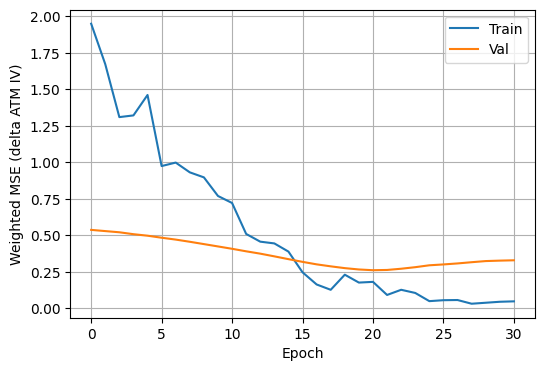

In [32]:
plt.figure(figsize=(6,4))
plt.plot(train_losses, label="Train")
plt.plot(val_losses, label = "Val")
plt.xlabel("Epoch")
plt.ylabel("Weighted MSE (delta ATM IV)")
plt.legend()
plt.grid(True)
plt.show()

In [33]:
model.eval()
y_true = []
y_pred = []
w_all  = []

with torch.no_grad():
    for Xb, yb, wb in test_loader:
        Xb = Xb.to(device)

        preds, _ = model(Xb)          # (batch,)
        preds = preds.cpu().numpy()

        y_true.append(yb.numpy())
        y_pred.append(preds)
        w_all.append(wb.numpy())

if len(y_true) > 0:
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)
    w_all  = np.concatenate(w_all)

    print("Eval diagnostics:")
    print("  y_true finite? ", np.all(np.isfinite(y_true)))
    print("  y_pred finite? ", np.all(np.isfinite(y_pred)))
    print("  w_all finite?  ", np.all(np.isfinite(w_all)))
    print("  any NaNs in y_pred?", np.isnan(y_pred).any())

    # Mask out any non-finite entries just in case
    mask = np.isfinite(y_true) & np.isfinite(y_pred) & np.isfinite(w_all)
    if mask.sum() == 0:
        print("No finite test points after masking – cannot compute metrics.")
    else:
        yt = y_true[mask]
        yp = y_pred[mask]
        ww = w_all[mask]

        # Normalise weights to avoid silly tiny sums
        ww = ww / ww.mean()

        mse_model = np.average((yt - yp)**2, weights=ww)
        mae_model = np.average(np.abs(yt - yp), weights=ww)

        y_base = np.zeros_like(yt)
        mse_base = np.average((yt - y_base)**2, weights=ww)
        mae_base = np.average(np.abs(yt - y_base), weights=ww)

        print("LSTM - weighted MSE:", mse_model)
        print("LSTM - weighted MAE:", mae_model)
        print("Baseline (delta=0) - weighted MSE:", mse_base)
        print("Baseline (delta=0) - weighted MAE:", mae_base)
else:
    print("No test sequences built")


Eval diagnostics:
  y_true finite?  True
  y_pred finite?  True
  w_all finite?   True
  any NaNs in y_pred? False
LSTM - weighted MSE: 0.30222914
LSTM - weighted MAE: 0.533696
Baseline (delta=0) - weighted MSE: 0.0
Baseline (delta=0) - weighted MAE: 0.0


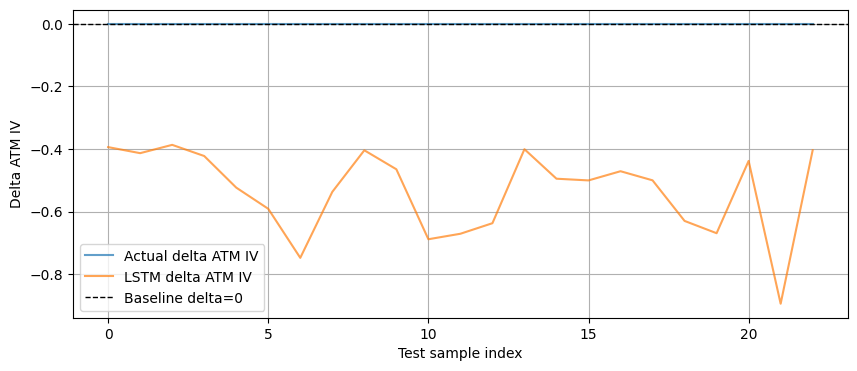

In [34]:
if len(y_true) > 0:
  idx = np.arange(len(y_true))
  subset = idx[: min(299, len(idx))]

  plt.figure(figsize=(10,4))
  plt.plot(subset, y_true[subset], label = "Actual delta ATM IV", alpha = 0.7)
  plt.plot(subset, y_pred[subset], label = "LSTM delta ATM IV", alpha = 0.7)
  plt.axhline(0.0, color = "black", linestyle = "--", linewidth=1, label = "Baseline delta=0")
  plt.xlabel("Test sample index")
  plt.ylabel("Delta ATM IV")
  plt.grid(True)
  plt.legend()
  plt.show()